In [136]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed 
from numba import jit

from sklearn.linear_model import LinearRegression
import scipy.linalg
from sklearn import linear_model
import sklearn.linear_model as skl
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

In [293]:
# Define the Franke Fumction
def frankeFunction(x1,x2,sig2):
    noise = np.random.normal(0,sig2,x1.shape)
    term1 = 0.75*np.exp(-(0.25*(9*x1-2)**2) - 0.25*((9*x2-2)**2))
    term2 = 0.75*np.exp(-((9*x1+1)**2)/49.0 - 0.1*(9*x2+1))
    term3 = 0.5*np.exp(-(9*x1-7)**2/4.0 - 0.25*((9*x2-3)**2))
    term4 = -0.2*np.exp(-(9*x1-4)**2 - (9*x2-7)**2)
    return term1 + term2 + term3 + term4 + noise

# Create the data points in mesh grid form
def createDataPoints(n, sig2):
    x1 = np.arange(0, 1, 1/n)
    x2 = np.arange(0, 1, 1/n)
#     x1 = np.sort(np.random.uniform(0, 5, n))
#     x2 = np.sort(np.random.uniform(0, 5, n))
    x1_d, x2_d = np.meshgrid(x1,x2)
    y_d = frankeFunction(x1_d,x2_d,sig2)
    return x1_d, x2_d, y_d.ravel()

# Create the design matrix with all possible combinations
@jit
def createDesignMatrix(x1, x2, n):
    if len(x1.shape) > 1:
        x1 = np.ravel(x1)
        x2 = np.ravel(x2)

    N = len(x1)
    p = int((n+1)*(n+2)/2)
    X = np.ones((N,p))

    for i in range(1, n+1):
        q = int(i*(i+1)/2)
        for j in range(i+1):
            X[:,q+j] = (x1**(i-j))*(x2**j)
    return X

# Predict the outcome using matrix inversion
def predict(X, y_data):
    beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y_data)
    y_tilde = X @ beta
    return y_tilde, beta

# Calculate the mean square error (MSE)
def MSE(y_data, y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

# Calculate the coefficient of determination (R2)
def R2(y_data, y_model):
    n = np.size(y_data)
    return 1 - np.sum((y_data-y_model)**2)/np.sum((y_data-(np.sum(y_data)/n))**2)

#Scale the data and split them for training and testing
def Scale(X_train, X_test):
    XX = np.copy(X_test)
    if X_train.shape[1] > 1:
        scaler = StandardScaler()
        scaler.fit(X_train[:,1:])
        X_train[:,1:] = scaler.transform(X_train[:,1:])
        XX[:,1:] = scaler.transform(XX[:,1:])  
    return X_train, XX#, y_train[:, np.newaxis], y_test[:, np.newaxis]

# Calculate the confidence interval of parameters Beta's
def CIBeta(X, Beta):
    varBeta = np.diagonal(np.linalg.pinv(X.T @ X)*sig2)
#     print(((X.T @ X)))
    print(varBeta.shape)
    print(Beta.shape)
    stdBeta = np.sqrt(varBeta)
    errorBeta = 1.645*stdBeta
    return errorBeta

# I cannot get this function to work with X_train
def SVDinv(A):
    U, s, VT = np.linalg.svd(A)
    print(A.shape)
    print(U.shape)
    print(s.shape)
    print(VT.shape)
    S = np.diag(s)
    UT = np.transpose(U)
    V = np.transpose(VT)
    invS = np.linalg.inv(S)
    #print(np.matmul(V,np.matmul(invD,UT)).shape)
    return np.matmul(V,np.matmul(invS,UT))

def kfoldCV(x,y,z,k=5):
    # The general procedure is as follows:
    # 1. Shuffle the dataset randomly.
    # 2. Split the dataset into k groups
    # 3. For each unique group:
    #    1. Take the group as a hold out or test data set
    #    2. Take the remaining groups as a training data set
    #    3. Fit a model on the training set and evaluate it on the test set
    #    4. Retain the evaluation score and discard the model
    # 4. Summarize the skill of the model using the sample of model evaluation scores
    
    #Concatenate the data points
    #data = np.concatenate((x,y),axis=0)
    
    #HOW TO COMBINE X AND Y IN THE RIGHT FORMAT?
    #First, split data into test and training set
    x_train, x_test, y_train, y_test = train_test_split(data,y,test_size=0.3)
    
    data = np.concatenate((x_train, y_train), axis=1)
    
    #Randomly shuffle the data
    np.random.shuffle(data)
    
    #Split data set into k parts
    splitData = np.array_split(data,k)
    
    for i in range(0,k):
        train = np.zeros((0,3)) #reset train set for each kth run
        for j in range(0,k):
            if j==i:
                test = splitData[j]
                continue
            train = np.concatenate((train, splitData[j]), axis=0)
        
        X_design = createDesignMatrix(train[:,0], train[:,1])
    

def ridgeRegression(X_train,X_test,y_train,nlambdas, plot):   
    N = np.size(X_train,1)
    I = np.eye(N)
    
    y_predict = np.zeros((nlambdas, X_test.shape[0]))
    y_ridgeSKL = np.zeros((nlambdas, X_test.shape[0]))
    # Decide which value of lambda to use
#     nlambdas = 4
    MSEPredict = np.zeros(nlambdas)
    MSETrain = np.zeros(nlambdas)
    MSEPredictSKL = np.zeros(nlambdas)
    lambdas = np.logspace(-4,1, nlambdas)
    for i in range(nlambdas):
        lmb = lambdas[i]
        # Add Ridge
        clf_ridge = skl.Ridge(alpha=lmb).fit(X_train,y_train)
        beta_ridge = np.linalg.inv(X_train.T @ X_train + lmb*I) @ X_train.T @ y_train
        # Make predictions
        y_tilde = X_train @ beta_ridge
        y_predict[i, :] = (X_test @ beta_ridge).squeeze()
        y_ridgeSKL[i, :] = clf_ridge.predict(X_test).squeeze()
        MSEPredict[i] = MSE(y_test, y_predict[i, :])
        MSETrain[i] = MSE(y_train, y_tilde)
        MSEPredictSKL[i] = MSE(y_test, y_ridgeSKL[i, :])
    if plot:
        plt.figure()
        plt.plot(np.log10(lambdas), MSETrain, label = 'MSE Ridge train')
        plt.plot(np.log10(lambdas), MSEPredict, 'r--', label = 'MSE Ridge Test')
        plt.plot(np.log10(lambdas), MSEPredictSKL, 'g--', label = 'MSE Ridge sickit-learn Test')
        plt.xlabel('log10(lambda)')
        plt.ylabel('MSE')
        plt.legend()
        plt.title(f'# Lambdas = {nlambdas}')
    return  y_predict

def lassoRegression(X_train,X_test,y_train,nlambdas, plot):
    N = np.size(X_train,1)
    I = np.eye(N)
    
    y_pred = np.zeros((nlambdas, X_test.shape[0]))
    # Decide which value of lambda to use
#     nlambdas = 4
    MSETrain = np.zeros(nlambdas)
    MSEPredictSKL = np.zeros(nlambdas)
    lambdas = np.logspace(-4,1, nlambdas)
    for i in range(nlambdas):
        lmb = lambdas[i]
        # Add Lasso
        clf_lasso = skl.Lasso(alpha=lmb).fit(X_train,y_train)
        # Make predictions
        y_tilde = clf_lasso.predict(X_train).squeeze()
        y_pred[i, :] = clf_lasso.predict(X_test).squeeze()
        MSETrain[i] = MSE(y_train, y_tilde)
        MSEPredictSKL[i] = MSE(y_test, y_pred[i, :])
    if plot:
        plt.figure()
        plt.plot(np.log10(lambdas), MSETrain, label = 'MSE Lasso train')
        plt.plot(np.log10(lambdas), MSEPredictSKL, 'g--', label = 'MSE Lasso Test')
        plt.xlabel('log10(lambda)')
        plt.ylabel('MSE')
        plt.legend()
        plt.title(f'# Lambdas = {nlambdas}')
    return  y_pred


    
    


a) OLS

The R2 value for a polynomial of order 4, OLS test: 0.7721300205898095
The MSE value for a polynomial of order 4, OLS test: 0.013464808333131394

The R2 value for a polynomial of order 4, OLS train: 0.9202775242105253
The MSE value for a polynomial of order 4, OLS train: 0.007666373089489403
(15,)
(15,)

The 90% confidence interval for beta_2 is -0.6854340385174038 ⟷ 2.2415105975529346


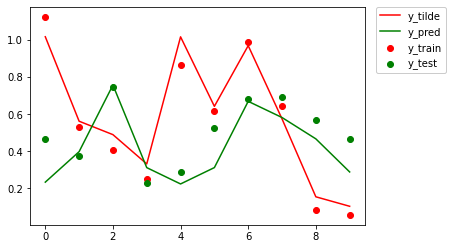

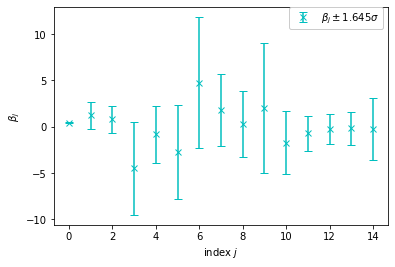

In [148]:
# np.random.seed(2020)

sig2 = 0.1 # noise variance
degree = 4 # polynomial degree
n = 10 # number of data points for each feature
x1, x2, y = createDataPoints(n, sig2)
X = createDesignMatrix(x1,x2,degree)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
X_train, X_test = Scale(X_train, X_test)

beta = np.linalg.pinv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
y_tilde = (X_train @ beta)
y_pred = (X_test @ beta)

ax0 = plt.figure(0)
# plt.plot(X_train[:, 1], y_tilde, label="y_tilde")
plt.plot(y_tilde[:10], label="y_tilde", color="red")
plt.scatter(np.arange(10), y_train[:10], label="y_train", color="red")

plt.plot(y_pred[:10], label="y_pred", color="green")
plt.scatter(np.arange(10), y_test[:10], label="y_test", color='green')
ax0.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.1, 0.9))


print(f"The R2 value for a polynomial of order {degree}, OLS test: {R2(y_test, y_pred)}")
print(f"The MSE value for a polynomial of order {degree}, OLS test: {MSE(y_test, y_pred)}")
print(f"\nThe R2 value for a polynomial of order {degree}, OLS train: {R2(y_train, y_tilde)}")
print(f"The MSE value for a polynomial of order {degree}, OLS train: {MSE(y_train, y_tilde)}")

# Calculate the confidence interval of the 'p' parameters beta
errorBeta = CIBeta(X_train, beta)

# Print an example of a confidence interval
print(f"\nThe 90% confidence interval for beta_2 is {beta[2]-errorBeta[2]} ⟷ {beta[2]+errorBeta[2]}")

# Plot the Confidence Intervals for the betas
ax1 = plt.figure(1)
plt.errorbar(np.arange(len(beta)), beta, errorBeta, fmt='cx', capsize=4, label=r"$\beta_j \pm 1.645 \sigma$")
plt.xlabel("index $j$")
plt.ylabel(r"$\beta_j $")
ax1.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(0.9, 0.9))

# fig3 = plt.figure(2)
# plt.scatter(X_train[:, 3], y_train)

b)

Polynomial degree: 0
Error: 0.09304829270052933
Bias^2: 0.09204223755982804
Var: 0.001006055140701291
0.09304829270052933 >= 0.09204223755982804 + 0.001006055140701291 = 0.09304829270052933

Polynomial degree: 1
Error: 0.038339460303301216
Bias^2: 0.037013985755732975
Var: 0.0013254745475682573
0.038339460303301216 >= 0.037013985755732975 + 0.0013254745475682573 = 0.03833946030330123

Polynomial degree: 2
Error: 0.02499229777465326
Bias^2: 0.022727349793554476
Var: 0.0022649479810987797
0.02499229777465326 >= 0.022727349793554476 + 0.0022649479810987797 = 0.024992297774653255

Polynomial degree: 3
Error: 0.014563528506379252
Bias^2: 0.01220963074962925
Var: 0.002353897756750002
0.014563528506379252 >= 0.01220963074962925 + 0.002353897756750002 = 0.014563528506379252

Polynomial degree: 4
Error: 0.015617868631644053
Bias^2: 0.008199919525022263
Var: 0.007417949106621792
0.015617868631644053 >= 0.008199919525022263 + 0.007417949106621792 = 0.015617868631644057

Polynomial degree: 5
Error

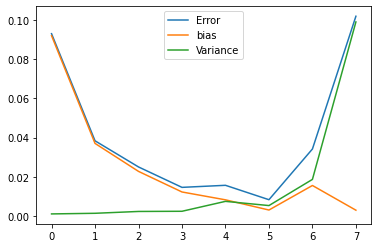

In [139]:
np.random.seed(26)
# print(np.random.get_state()[1][0])

sig2 = 0.01 # noise variance
n = 10 # number of data points for each feature
n_boostraps = 200 # number of bootstraps 
maxdegree = 7 # maximum polynomial degree

for n in range(10,11):
#     print(n)
    # Make data set.
    x1, x2, y = createDataPoints(n, sig2)
    x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)
#     print(x.shape)

    # Define empty arrays
    error = np.zeros(maxdegree+1)
    bias = np.zeros(maxdegree+1)
    variance = np.zeros(maxdegree+1)
    polydegree = np.zeros(maxdegree+1)


    for degree in range(maxdegree+1):
#         print("\n", degree, "\n")
        X = createDesignMatrix(x[:,[0]],x[:,[1]],degree)  
        
        # Split and scale the design data
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
        y_train, y_test = y_train[:, np.newaxis], y_test[:, np.newaxis]
#         X_test.flags.writeable = False
        y_pred = np.empty((y_test.shape[0], n_boostraps))
        for i in range(n_boostraps):
#             print(i)
            x_, y_ = resample(X_train, y_train)
#             print("X_test before", X_test[:1, :])

            x_, X_test2 = Scale(x_, X_test)
#             print("X_test after", X_test2[:1, :])

            beta = np.linalg.pinv(x_.T.dot(x_)).dot(x_.T).dot(y_)
            y_pred[:, i] = (X_test2 @ beta).squeeze()

        polydegree[degree] = degree
        error[degree] = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
        bias[degree] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
        variance[degree] = np.mean( np.var(y_pred, axis=1, keepdims=True) )
        print("Polynomial degree:", degree)
        print("Error:", error[degree])
        print("Bias^2:", bias[degree])
        print("Var:", variance[degree])
        print('{} >= {} + {} = {}\n'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))

    plt.plot(polydegree, error, label="Error")
    plt.plot(polydegree, bias, label="bias")
    plt.plot(polydegree, variance, label="Variance")
    plt.legend()
    plt.show()

c)

In [251]:
np.random.seed(26)

sig2 = 0.01 # noise variance
n = 10 # number of data points for each feature
K = [5, 10]
degree = 7

x1, x2, y = createDataPoints(n, sig2)
x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)

X = createDesignMatrix(x[:,[0]],x[:,[1]],degree)  
p = np.random.permutation(X.shape[0])
X = X[p]
y = y[p]

print("Polynomial degree:", degree)

for k in K:

    #Split data set into k parts
    splitXData = np.array(np.split(X,k))
    splitYData = np.array(np.split(y,k))
    MSErrors = np.zeros(k)

    s0 = splitXData.shape[0]
    s1 = splitXData.shape[1]

    for i in range(0,k):
        mask = np.ones(k)
        mask[i]=0
        X_train = splitXData[mask==1].reshape(((s0-1)*s1,-1))
        X_test = splitXData[mask==0].squeeze()
        X_train, X_test = Scale(X_train, X_test)

        y_train = splitYData[mask==1].reshape(((s0-1)*s1,1))
        y_test = np.swapaxes(splitYData[mask==0], 0, 1)

        beta = np.linalg.pinv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
        y_pred = (X_test @ beta)

        MSErrors[i] = np.mean((y_test - y_pred)**2, keepdims=True)
#         print(MSErrors[i])
    MSError = np.mean(MSErrors)

    print("%s fold MSE:"% k, MSError)

Polynomial degree: 7
5
20
5 fold MSE: 0.0033216318833721213
10
10
10 fold MSE: 0.0020835870696384617


In [141]:
np.random.seed(26)

sig2 = 0.01 # noise variance
n = 10 # number of data points for each feature
K = [5, 10]
degree = 7

x1, x2, y = createDataPoints(n, sig2)
x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)

# X = createDesignMatrix(x[:,[0]],x[:,[1]],degree)  
# p = np.random.permutation(X.shape[0])
# X = X[p]
# y = y[p]

poly = PolynomialFeatures(degree = 7)

OLS = LinearRegression(fit_intercept=False)
X = poly.fit_transform(x)
X = X[p]
y = y[p]
estimated_mse_folds = cross_val_score(OLS, X, y[:, np.newaxis], scoring='neg_mean_squared_error', cv=10)
# cross_val_score return an array containing the estimated negative mse for every fold.
# we have to the the mean of every array in order to get an estimate of the mse of the model
estimated_mse_sklearn = np.mean(-estimated_mse_folds)

print(estimated_mse_sklearn)

0.0020835879224487116


In [142]:
k = 10
kfold = KFold(n_splits = k)

scores_KFold = np.zeros(k)
scores_KFold2 = np.zeros(k)

np.random.seed(26)

sig2 = 0.01 # noise variance
n = 10 # number of data points for each feature

x1, x2, y = createDataPoints(n, sig2)
x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)

poly = PolynomialFeatures(degree = 7)

OLS = LinearRegression(fit_intercept=False)

p = np.random.permutation(x.shape[0])
x = x[p]
y = y[p]

j = 0
for train_inds, test_inds in kfold.split(x):
    xtrain = x[train_inds]
    ytrain = y[train_inds]
    xtest = x[test_inds]
    ytest = y[test_inds]
    Xtrain = poly.fit_transform(xtrain)
    OLS.fit(Xtrain, ytrain[:, np.newaxis])
    Xtest = poly.fit_transform(xtest)
    ypred = OLS.predict(Xtest)
    
#     beta = np.linalg.pinv(Xtrain.T.dot(Xtrain)).dot(Xtrain.T).dot(ytrain)
#     ypred2 = (Xtest @ beta)
#     print((ypred - ytest[:, np.newaxis]).shape)
#     print((ypred2[:, np.newaxis] - ytest[:, np.newaxis]).shape)
    
#     print(ypred)
#     print(ypred2[:, np.newaxis])
    
    scores_KFold[j] = np.mean((ypred - ytest[:, np.newaxis])**2)
    
#     scores_KFold2[j] = np.mean((ypred2[:, np.newaxis] - ytest[:, np.newaxis])**2)
    j += 1
    
#     break
estimated_mse_KFold = np.mean(scores_KFold, axis = 0)

# estimated_mse_KFold2 = np.mean(scores_KFold2, axis = 0)

print(estimated_mse_KFold)
# print(estimated_mse_KFold2)

0.0020835879224487116


In [143]:
print(estimated_mse_KFold)

0.0020835879224487116


d)

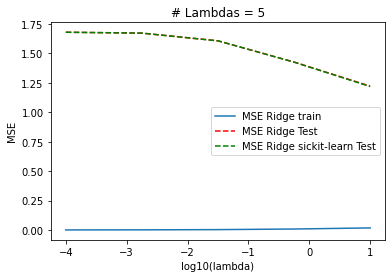

In [292]:
_ = ridgeRegression(X_train, X_test,y_train,nlambdas=5, plot=True)

Bootstrap with Ridge

Polynomial degree: 0
Error: [0.09202979 0.09202991 0.09203735 0.09533053]
Bias^2: [0.09202979 0.09202991 0.09203735 0.09533053]
Var: [0. 0. 0. 0.]
[0.09202979 0.09202991 0.09203735 0.09533053] >= [0.09202979 0.09202991 0.09203735 0.09533053] + [0. 0. 0. 0.] = [0.09202979 0.09202991 0.09203735 0.09533053]

Polynomial degree: 1
Error: [0.07982476 0.07982547 0.07986013 0.08426419]
Bias^2: [0.07662241 0.07662358 0.07667933 0.08186883]
Var: [0.00320235 0.0032019  0.00318081 0.00239535]
[0.07982476 0.07982547 0.07986013 0.08426419] >= [0.07662241 0.07662358 0.07667933 0.08186883] + [0.00320235 0.0032019  0.00318081 0.00239535] = [0.07982476 0.07982547 0.07986013 0.08426419]

Polynomial degree: 2
Error: [0.09814557 0.09813625 0.09777963 0.10297877]
Bias^2: [0.09218285 0.09218558 0.09231577 0.10060253]
Var: [0.00596272 0.00595067 0.00546386 0.00237624]
[0.09814557 0.09813625 0.09777963 0.10297877] >= [0.09218285 0.09218558 0.09231577 0.10060253] + [0.00596272 0.00595067 0.00546386 0.00237624] 

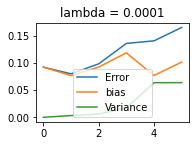

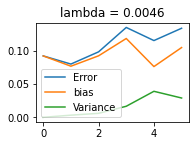

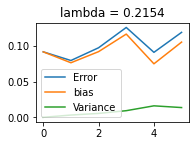

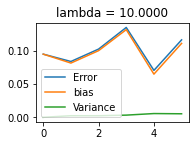

In [249]:
np.random.seed(26)
# print(np.random.get_state()[1][0])

sig2 = 0.01 # noise variance
n = 10 # number of data points for each feature
n_boostraps = 200 # number of bootstraps 
maxdegree = 5 # maximum polynomial degree
nlambdas = 4

# for  in range(10,11):
# Make data set.
x1, x2, y = createDataPoints(n, sig2)
x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)

# Define empty arrays
error = np.zeros((maxdegree+1, nlambdas))
bias = np.zeros((maxdegree+1, nlambdas))
variance = np.zeros((maxdegree+1, nlambdas))
polydegree = np.zeros( maxdegree+1)

for degree in range(maxdegree+1):
    X = createDesignMatrix(x[:,[0]],x[:,[1]],degree)  

    # Split and scale the design data
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
    y_train, y_test = y_train[:, np.newaxis], y_test[:, np.newaxis]
    
    y_pred = np.empty((nlambdas, y_test.shape[0], n_boostraps))
    
    for i in range(n_boostraps):
        x_, y_ = resample(X_train, y_train)

        x_, X_test2 = Scale(x_, X_test)
        
        y_pred[:, :, i] = ridgeRegression(x_, X_test2,y_train,nlambdas, plot=False)

    polydegree[degree] = degree
    error[degree, :] = np.mean(np.mean((y_test - y_pred)**2, axis=1, keepdims=True), axis=2).squeeze()
    bias[degree, :] = np.mean( (y_test - np.mean(y_pred, axis=2, keepdims=True))**2, axis=1).squeeze()
    variance[degree, :] = np.mean( np.var(y_pred, axis=2, keepdims=True) , axis=1).squeeze()

    print("Polynomial degree:", degree)
    print("Error:", error[degree])
    print("Bias^2:", bias[degree])
    print("Var:", variance[degree])
    print('{} >= {} + {} = {}\n'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))

lambdas = np.logspace(-4,1, nlambdas)

for k in range(nlambdas):
    plt.subplot(2,2,k+1)
    plt.plot(polydegree, error[:, k], label="Error")
    plt.plot(polydegree, bias[:, k], label="bias")
    plt.plot(polydegree, variance[:, k], label="Variance")
    plt.legend()
    plt.title('lambda = %0.4f' %lambdas[k])
    plt.show()

Cross validation with Ridge

In [273]:
np.random.seed(26)

sig2 = 0.01 # noise variance
n = 10 # number of data points for each feature
K = [5, 10]
degree = 7
nlambdas = 4

x1, x2, y = createDataPoints(n, sig2)
x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)

X = createDesignMatrix(x[:,[0]],x[:,[1]],degree)  
p = np.random.permutation(X.shape[0])
X = X[p]
y = y[p]

print("Polynomial degree:", degree)

for k in K:

    #Split data set into k parts
    splitXData = np.array(np.split(X,k))
    splitYData = np.array(np.split(y,k))
    MSErrors = np.zeros((nlambdas, k))

    s0 = splitXData.shape[0]
    s1 = splitXData.shape[1]
    
    y_pred = np.empty((nlambdas, s1))

    for i in range(0,k):
        mask = np.ones(k)
        mask[i]=0
        X_train = splitXData[mask==1].reshape(((s0-1)*s1,-1))
        X_test = splitXData[mask==0].squeeze()
        X_train, X_test = Scale(X_train, X_test)

        y_train = splitYData[mask==1].reshape(((s0-1)*s1,1))
        y_test = np.swapaxes(splitYData[mask==0], 0, 1)
        
        y_pred = ridgeRegression(X_train, X_test,y_train, nlambdas, plot=False)

        MSErrors[:, i] = np.mean((y_test.squeeze() - y_pred)**2, keepdims=True, axis=1).squeeze()
    MSError = np.mean(MSErrors, axis=1)

    print("%s fold MSE:"% k, MSError)

Polynomial degree: 7
5 fold MSE: [0.00396176 0.00575206 0.0097047  0.02142667]
10 fold MSE: [0.00364082 0.00385706 0.00920423 0.02012492]


e)

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18019378273783565, tolerance: 0.0007123159910905648
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007924975210900076, tolerance: 0.0007123159910905648
  positive)


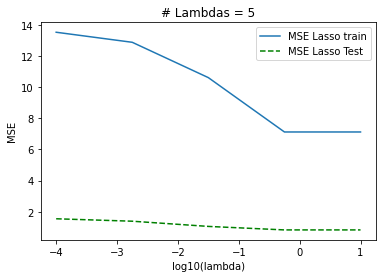

In [294]:
_ = lassoRegression(X_train, X_test,y_train, nlambdas=5, plot=True)